In [2]:
from os.path import isdir, join
import pickle
import numpy as np
import matplotlib.pyplot as plt
# import rosbag
import glob
from sklearn.model_selection import train_test_split, KFold
import os
import pdb
import math
import torch
from datetime import datetime
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from os.path import join
from os import makedirs
import time
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
dataset_filepath = 'short_prediction_data.pt'
dataset = torch.load(dataset_filepath)

xobs_train, xpred_train, yintention_train, xobs_test, xpred_test, yintention_test = \
dataset["xobs_train"], dataset["xpred_train"], dataset["yintention_train"], dataset["xobs_test"], \
dataset["xpred_test"], dataset["yintention_test"]
obs_seq_len, pred_seq_len = dataset["obs_seq_len"], dataset["pred_seq_len"]


In [4]:
class Arguments:
    def __init__(
        self,
        batch_size=32,
        obs_seq_len=4,
        pred_seq_len=6,
        embedding_size=32,
        hidden_size=32,
        num_layers=1,
        dropout=0.,
        lr=1e-3,
        num_epochs=100,
        clip_grad=10.,
        device="cuda:0",
        checkpoint_dir="checkpoints",
        ):
        self.batch_size = batch_size
        self.obs_seq_len = obs_seq_len
        self.pred_seq_len = pred_seq_len
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        self.num_epochs = num_epochs
        self.clip_grad = clip_grad
        self.device = device
        self.checkpoint_dir=checkpoint_dir

args = Arguments(
    obs_seq_len=obs_seq_len,
    pred_seq_len=pred_seq_len,
    lr=5e-3,
    device=device,
)

In [5]:
class TrajectoriesDataset(Dataset):
    def __init__(
        self,
        xobs,
        xpred,
        yintention,
        obs_seq_len=4,
        pred_seq_len=6,
        ):
        super(TrajectoriesDataset, self).__init__()
        assert xobs.shape[0]==xpred.shape[0]==yintention.shape[0]
        assert xobs.shape[1]==obs_seq_len and xpred.shape[1]==pred_seq_len
        self.obs_seq_len = obs_seq_len
        self.pred_seq_len = pred_seq_len
        self.seq_len = self.obs_seq_len + self.pred_seq_len
        self.xobs = xobs
        self.xpred = xpred
        self.yintention = yintention
        self.num_seq = self.xobs.shape[0]

    def __len__(self):
        return self.num_seq


    def __getitem__(self, index):
        out = [
            self.xobs[index],
            self.xpred[index],
            self.yintention[index],
        ]
        return out

In [6]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, validation_index in kf.split(xobs_train):
    xobs_train_k, xobs_val_k = xobs_train[train_index], xobs_train[validation_index]
    xpred_train_k, xpred_val_k = xpred_train[train_index], xpred_train[validation_index] 
    yintention_train_k, yintention_val_k = yintention_train[train_index], yintention_train[validation_index]
    dataset_train = TrajectoriesDataset(
        xobs_train_k,
        xpred_train_k,
        yintention_train_k,
        obs_seq_len=obs_seq_len,
        pred_seq_len=pred_seq_len,
    )
    dataset_val = TrajectoriesDataset(
        xobs_val_k,
        xpred_val_k,
        yintention_val_k,
        obs_seq_len=obs_seq_len,
        pred_seq_len=pred_seq_len,
    )
    loader_train = DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=4,  
    )
    loader_val = DataLoader(
        dataset_val,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=4,  
    )
    break

    
dataset_test = TrajectoriesDataset(
    xobs_test,
    xpred_test,
    yintention_test,
    obs_seq_len=obs_seq_len,
    pred_seq_len=pred_seq_len,
)

loader_test = DataLoader(
    dataset_test,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=4,  
)


In [7]:
class IntentionLstm(nn.Module):
    def __init__(
        self,
        embedding_size=32,
        hidden_size=32,
        num_layers=1,
        dropout=0.,
        bidirectional=False,
        obs_seq_len=4,
        pred_seq_len=6,
    ):
        super(IntentionLstm, self).__init__()
        self.lstm = nn.LSTM(
            input_size=2*embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional,
            )
        self.spatial_embedding = nn.Linear(2, embedding_size)
        self.intention_embedding = nn.Linear(1, embedding_size)
        if bidirectional:
            self.directions = 2
        else:
            self.directions = 1
        self.hidden_to_pos = nn.Linear(self.directions*num_layers*hidden_size, 2)
        self.embedding_size = embedding_size
        self.obs_seq_len = obs_seq_len
        self.pred_seq_len = pred_seq_len
    
    def forward(self, b_xobs, b_yintention, device="cuda:0"):
        
        """
        Forward function.
        inputs:
            - b_xobs: batch of observation. (batch, obs_seq_len, 2)
            - b_yintention: batch of intention. (batch, 1)
        outputs:
            - b_xpred: (batch, pred_seq_len, 2)
            
        """
        batch_size, _, _ = b_xobs.shape
        b_xobs = self.spatial_embedding(b_xobs) # (batch, obs_seq_len, embedding_size)
        b_yintention = self.intention_embedding(b_yintention.unsqueeze(-1)) # (batch, 1, embedding_size)
        b_yintention_obs = b_yintention*torch.ones(batch_size, self.obs_seq_len, self.embedding_size).to(device)
        b_obs = torch.cat((b_xobs, b_yintention_obs),dim=2) # (batch, obs_seq_len, 2*embedding_size)
        _, (ht, ct) = self.lstm(b_obs) # (D∗num_layers, batch, hidden_size)
        b_xpred = []
        b_xpred_tt = self.hidden_to_pos(ht.permute(1,0,2).reshape(batch_size,1,-1)) # (batch, 1, 2)
        b_xpred.append(b_xpred_tt)
        for tt in range(1, self.pred_seq_len):
            b_pred_tt = torch.cat((self.spatial_embedding(b_xpred_tt), b_yintention), dim=2)
            _, (ht, ct) = self.lstm(b_pred_tt, (ht, ct))
            b_xpred_tt = self.hidden_to_pos(ht.permute(1,0,2).reshape(batch_size,1,-1)) # (batch, 1, 2)
            b_xpred.append(b_xpred_tt)
        b_xpred = torch.cat(b_xpred, dim=1)
        return b_xpred


In [8]:
def train(args, loader_train, loader_val):
    model = IntentionLstm(
        embedding_size=args.embedding_size,
        hidden_size=args.hidden_size,
        num_layers=args.num_layers,
        dropout=args.dropout,
        bidirectional=False,
        obs_seq_len=args.obs_seq_len,
        pred_seq_len=args.pred_seq_len,
    ).to(args.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    now = datetime.now()
    curr_checkpoint_dir = join(args.checkpoint_dir, now.strftime("%y%m%d_%H%M%S"))
    if not isdir(curr_checkpoint_dir):
        makedirs(curr_checkpoint_dir)
    with open(join(curr_checkpoint_dir, 'args.pickle'), 'wb') as f:
        pickle.dump(args, f)
    print('EPOCHS: ', args.num_epochs)
    train_loss_task, train_aoe_task, train_foe_task = [], [], []
    val_loss_task, val_aoe_task, val_foe_task = [], [], []
    
    for epoch in range(1, args.num_epochs+1):
        epoch_start_time = time.time()
        model.train()
        train_loss_epoch, train_aoe_epoch, train_foe_epoch = [], [], []
        for batch_idx, batch in enumerate(loader_train):
            batch = [b.to(args.device) for b in batch]
            b_xobs, b_xpred_gt, b_yintention = batch
            optimizer.zero_grad()
            b_xpred = model(b_xobs, b_yintention, device=args.device) # (batch, pred_seq_len, 2)
            loss = ((b_xpred-b_xpred_gt)**2.).mean()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)
            optimizer.step()
            offset_error = (((b_xpred-b_xpred_gt)**2.).sum(2))**0.5 # (batch, pred_seq_len)
            aoe, foe = offset_error.mean(-1).mean(), offset_error[-1].mean()
            train_loss_epoch.append(loss.detach().to('cpu').item())
            train_aoe_epoch.append(aoe.detach().to('cpu').item())
            train_foe_epoch.append(foe.detach().to('cpu').item())
        train_loss_epoch = sum(train_loss_epoch)/len(train_loss_epoch)
        train_aoe_epoch = sum(train_aoe_epoch)/len(train_aoe_epoch)
        train_foe_epoch = sum(train_foe_epoch)/len(train_foe_epoch)
        val_loss_epoch, val_aoe_epoch, val_foe_epoch = inference(args, loader_val, model)
        if epoch % 10 == 0:
#             print('Epoch: {0} | train loss: {1:.2f} | val loss: {2:.2f} | train aoe: {3:.2f} | val aoe: {4:.2f} | train foe: {5:.2f} | val foe: {6:.2f} | period: {7:.2f} sec'\
#                 .format(epoch, train_loss_epoch, val_loss_epoch,\
#                 train_aoe_epoch, val_aoe_epoch,\
#                 train_foe_epoch, val_foe_epoch,\
#                 time.time()-epoch_start_time)) 
            print('Epoch: {0} | train aoe: {1:.2f} | val aoe: {2:.2f} | train foe: {3:.2f} | val foe: {4:.2f} | period: {5:.2f} sec'\
                .format(epoch, \
                train_aoe_epoch, val_aoe_epoch,\
                train_foe_epoch, val_foe_epoch,\
                time.time()-epoch_start_time)) 
            model_filename = join(curr_checkpoint_dir, 'epoch_'+str(epoch)+'.pt')
            torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss_epoch,
                    'val_loss': val_loss_epoch,
                    'train_aoe': train_aoe_epoch,
                    'val_aoe': val_aoe_epoch, 
                    'train_foe': train_foe_epoch,
                    'val_foe': val_foe_epoch,   
                    }, model_filename)
            # print('epoch_'+str(epoch)+'.pt is saved.')
        train_loss_task.append(train_loss_epoch)
        train_aoe_task.append(train_aoe_epoch)
        train_foe_task.append(train_foe_epoch)
        val_loss_task.append(val_loss_epoch)
        val_aoe_task.append(val_aoe_epoch)
        val_foe_task.append(val_foe_epoch)
    hist = {}
    hist['train_loss'], hist['val_loss'] = train_loss_task, val_loss_task
    hist['train_aoe'], hist['val_aoe'] = train_aoe_task, val_aoe_task
    hist['train_foe'], hist['val_foe'] = train_foe_task, val_foe_task
    with open(join(curr_checkpoint_dir, 'train_hist.pickle'), 'wb') as f:
        pickle.dump(hist, f)
        print(join(curr_checkpoint_dir, 'train_hist.pickle')+' is saved.')
    return


def inference(args, loader, model):
    with torch.no_grad():
        model.eval()
        loss_epoch, aoe_epoch, foe_epoch = [], [], []
        for batch_idx, batch in enumerate(loader):
            batch = [b.to(args.device) for b in batch]
            b_xobs, b_xpred_gt, b_yintention = batch
            b_xpred = model(b_xobs, b_yintention, device=args.device) # (batch, pred_seq_len, 2)
            loss = ((b_xpred-b_xpred_gt)**2.).mean()
            offset_error = (((b_xpred-b_xpred_gt)**2.).sum(2))**0.5 # (batch, pred_seq_len)
            aoe, foe = offset_error.mean(-1).mean(), offset_error[-1].mean()
            loss_epoch.append(loss.detach().to('cpu').item())
            aoe_epoch.append(aoe.detach().to('cpu').item())
            foe_epoch.append(foe.detach().to('cpu').item())
        loss_epoch = sum(loss_epoch)/len(loss_epoch)
        aoe_epoch = sum(aoe_epoch)/len(aoe_epoch)
        foe_epoch = sum(foe_epoch)/len(foe_epoch)
    return loss_epoch, aoe_epoch, foe_epoch

In [8]:
train(args, loader_train, loader_val)

EPOCHS:  100
Epoch: 10 | train aoe: 297.71 | val aoe: 294.10 | train foe: 305.80 | val foe: 300.37 | period: 0.32 sec
Epoch: 20 | train aoe: 252.74 | val aoe: 249.53 | train foe: 254.81 | val foe: 256.25 | period: 0.32 sec
Epoch: 30 | train aoe: 209.17 | val aoe: 206.42 | train foe: 214.65 | val foe: 213.68 | period: 0.32 sec
Epoch: 40 | train aoe: 167.14 | val aoe: 165.08 | train foe: 168.63 | val foe: 173.00 | period: 0.32 sec
Epoch: 50 | train aoe: 127.65 | val aoe: 126.36 | train foe: 120.79 | val foe: 135.07 | period: 0.32 sec
Epoch: 60 | train aoe: 92.19 | val aoe: 92.32 | train foe: 88.53 | val foe: 102.04 | period: 0.31 sec
Epoch: 70 | train aoe: 66.50 | val aoe: 68.79 | train foe: 61.66 | val foe: 79.27 | period: 0.31 sec
Epoch: 80 | train aoe: 58.05 | val aoe: 60.65 | train foe: 66.23 | val foe: 64.72 | period: 0.31 sec
Epoch: 90 | train aoe: 58.01 | val aoe: 60.39 | train foe: 70.35 | val foe: 61.76 | period: 0.32 sec
Epoch: 100 | train aoe: 58.03 | val aoe: 60.40 | train fo

In [36]:
def test(loader_test, name_checkpoint, visualize=True):
    curr_checkpoint_dir = join(args.checkpoint_dir, name_checkpoint)
    if not isdir(curr_checkpoint_dir):
        raise RuntimeError("Checkpoint "+name_checkpoint+" does not exist.")
    with open(join(curr_checkpoint_dir, 'args.pickle'), 'rb') as f:
        args_eval = pickle.load(f)
    model = IntentionLstm(
        embedding_size=args.embedding_size,
        hidden_size=args.hidden_size,
        num_layers=args.num_layers,
        dropout=args.dropout,
        bidirectional=False,
        obs_seq_len=args.obs_seq_len,
        pred_seq_len=args.pred_seq_len,
    ).to(args.device)
    model_checkpoint_filename = join(curr_checkpoint_dir, "epoch_"+str(args.num_epochs)+".pt")
    model_checkpoint = torch.load(model_checkpoint_filename, map_location=device)
    model.load_state_dict(model_checkpoint['model_state_dict'])
    print('Loaded configuration: ', model_checkpoint_filename)
    start_time = time.time()
    test_loss_epoch, test_aoe_epoch, test_foe_epoch = inference(args, loader_test, model)
    print('Epoch: {0} | test aoe: {1:.2f} | test foe: {2:.2f} | period: {3:.2f} sec'\
        .format(args.num_epochs, \
        test_aoe_epoch,\
        test_foe_epoch,\
        time.time()-start_time))
    if visualize:
        with torch.no_grad():
            model.eval()
            for batch_idx, batch in enumerate(loader_test):
                batch = [b.to(args.device) for b in batch]
                b_xobs, b_xpred_gt, b_yintention = batch
                b_xpred = model(b_xobs, b_yintention, device=args.device) # (batch, pred_seq_len, 2)
                b_x_gt = torch.cat([b_xobs, b_xpred_gt],dim=1).to("cpu")
                b_x_model = torch.cat([b_xobs, b_xpred],dim=1).to("cpu")
                for traj_idx in range(len(b_xobs)):
                    plt.figure()
                    plt.plot(b_x_gt[traj_idx,:,0], b_x_gt[traj_idx,:,1], 'o-', c='C0') # blue
                    plt.plot(b_x_model[traj_idx,:,0], b_x_model[traj_idx,:,1], 'o-', c='C1') # orange
                    print(b_x_model[traj_idx])
                    print(b_yintention[traj_idx])
                    plt.show()
                #break
        



Loaded configuration:  checkpoints/211015_213739/epoch_100.pt
Epoch: 100 | test aoe: 60.02 | test foe: 69.08 | period: 0.09 sec
tensor([[191.0000, 215.0000],
        [192.0000, 214.0000],
        [198.0000, 218.0000],
        [204.0000, 218.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


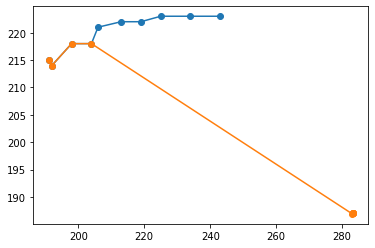

tensor([[198.0000, 218.0000],
        [204.0000, 218.0000],
        [206.0000, 221.0000],
        [213.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


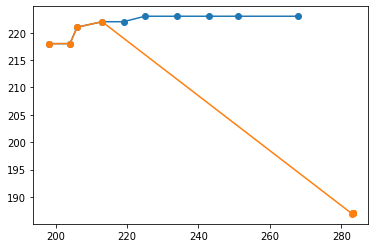

tensor([[206.0000, 221.0000],
        [213.0000, 222.0000],
        [219.0000, 222.0000],
        [225.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


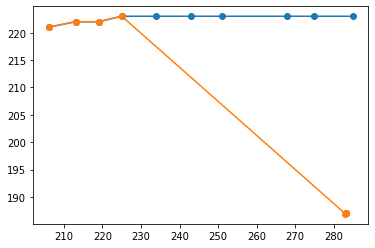

tensor([[219.0000, 222.0000],
        [225.0000, 223.0000],
        [234.0000, 223.0000],
        [243.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


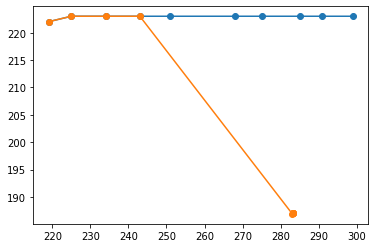

tensor([[234.0000, 223.0000],
        [243.0000, 223.0000],
        [251.0000, 223.0000],
        [268.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


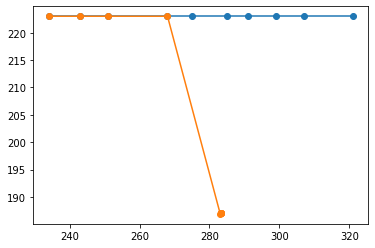

tensor([[251.0000, 223.0000],
        [268.0000, 223.0000],
        [275.0000, 223.0000],
        [285.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


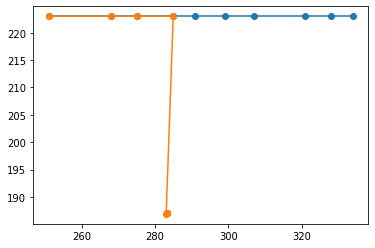

tensor([[275.0000, 223.0000],
        [285.0000, 223.0000],
        [291.0000, 223.0000],
        [299.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


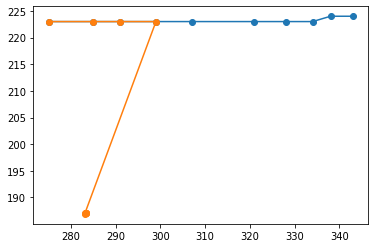

tensor([[291.0000, 223.0000],
        [299.0000, 223.0000],
        [307.0000, 223.0000],
        [321.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


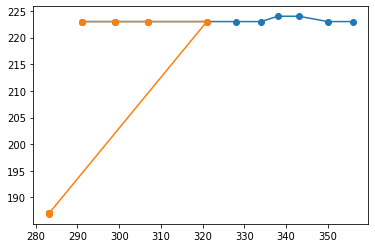

tensor([[192.0000, 214.0000],
        [193.0000, 214.0000],
        [198.0000, 217.0000],
        [202.0000, 218.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


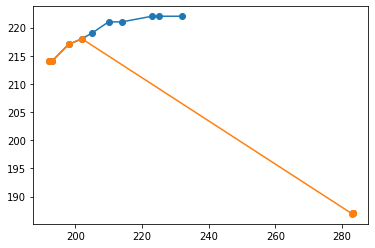

tensor([[198.0000, 217.0000],
        [202.0000, 218.0000],
        [205.0000, 219.0000],
        [210.0000, 221.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


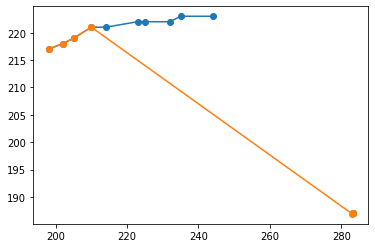

tensor([[205.0000, 219.0000],
        [210.0000, 221.0000],
        [214.0000, 221.0000],
        [223.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


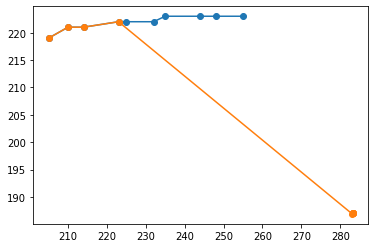

tensor([[214.0000, 221.0000],
        [223.0000, 222.0000],
        [225.0000, 222.0000],
        [232.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


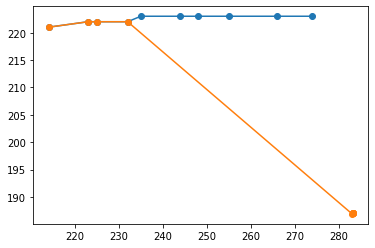

tensor([[225.0000, 222.0000],
        [232.0000, 222.0000],
        [235.0000, 223.0000],
        [244.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


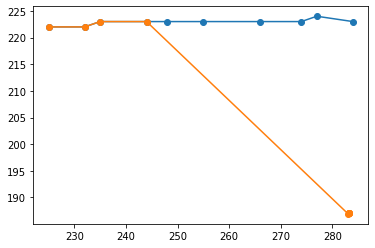

tensor([[235.0000, 223.0000],
        [244.0000, 223.0000],
        [248.0000, 223.0000],
        [255.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


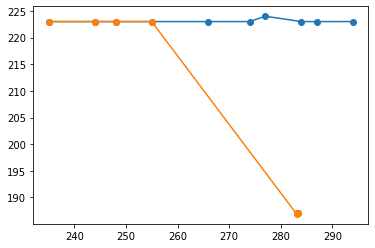

tensor([[248.0000, 223.0000],
        [255.0000, 223.0000],
        [266.0000, 223.0000],
        [274.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


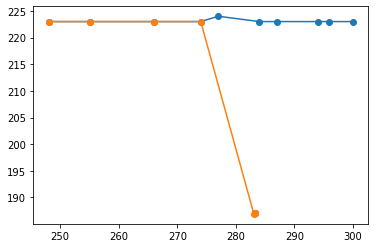

tensor([[266.0000, 223.0000],
        [274.0000, 223.0000],
        [277.0000, 224.0000],
        [284.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


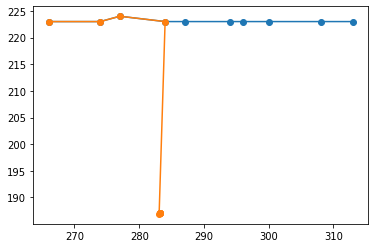

tensor([[277.0000, 224.0000],
        [284.0000, 223.0000],
        [287.0000, 223.0000],
        [294.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


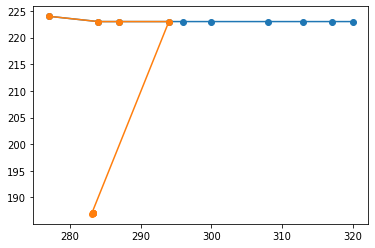

tensor([[287.0000, 223.0000],
        [294.0000, 223.0000],
        [296.0000, 223.0000],
        [300.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


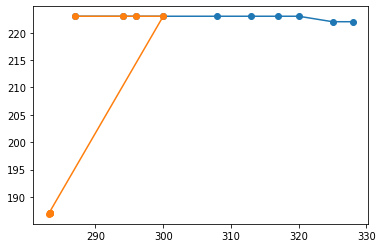

tensor([[296.0000, 223.0000],
        [300.0000, 223.0000],
        [308.0000, 223.0000],
        [313.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


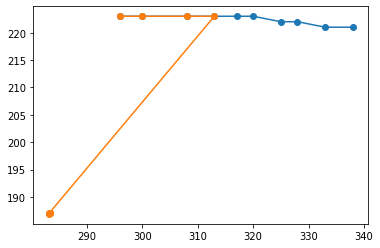

tensor([[308.0000, 223.0000],
        [313.0000, 223.0000],
        [317.0000, 223.0000],
        [320.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


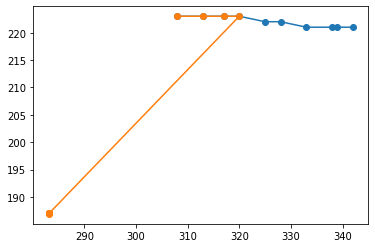

tensor([[317.0000, 223.0000],
        [320.0000, 223.0000],
        [325.0000, 222.0000],
        [328.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


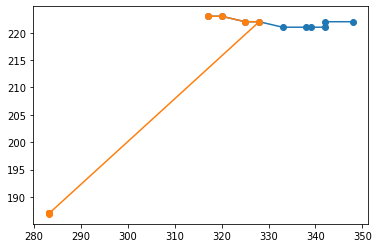

tensor([[325.0000, 222.0000],
        [328.0000, 222.0000],
        [333.0000, 221.0000],
        [338.0000, 221.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


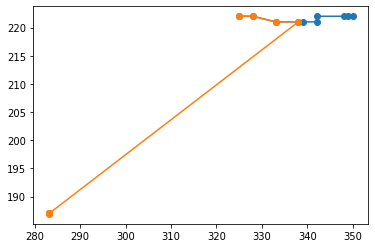

tensor([[333.0000, 221.0000],
        [338.0000, 221.0000],
        [339.0000, 221.0000],
        [342.0000, 221.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


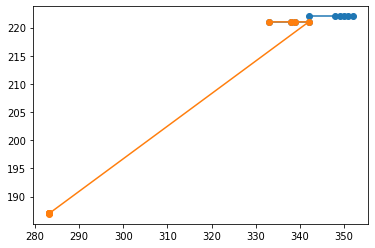

tensor([[339.0000, 221.0000],
        [342.0000, 221.0000],
        [342.0000, 222.0000],
        [348.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


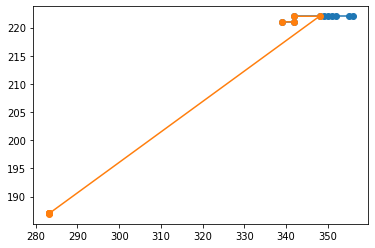

tensor([[184.0000, 215.0000],
        [185.0000, 215.0000],
        [187.0000, 215.0000],
        [188.0000, 215.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


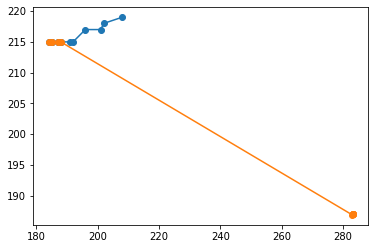

tensor([[187.0000, 215.0000],
        [188.0000, 215.0000],
        [191.0000, 215.0000],
        [192.0000, 215.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


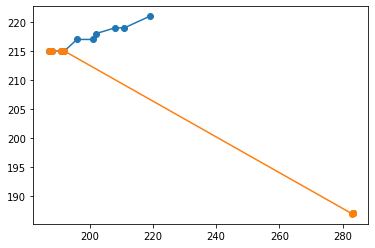

tensor([[191.0000, 215.0000],
        [192.0000, 215.0000],
        [196.0000, 217.0000],
        [201.0000, 217.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


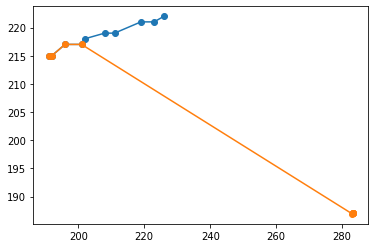

tensor([[196.0000, 217.0000],
        [201.0000, 217.0000],
        [202.0000, 218.0000],
        [208.0000, 219.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


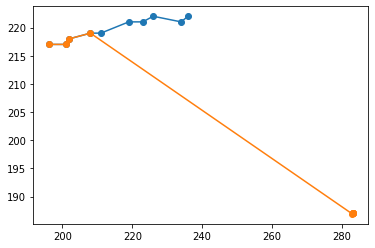

tensor([[202.0000, 218.0000],
        [208.0000, 219.0000],
        [211.0000, 219.0000],
        [219.0000, 221.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


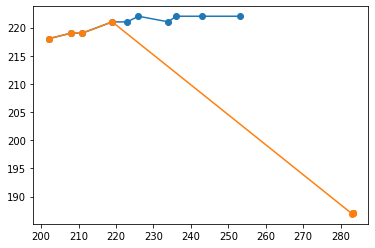

tensor([[211.0000, 219.0000],
        [219.0000, 221.0000],
        [223.0000, 221.0000],
        [226.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


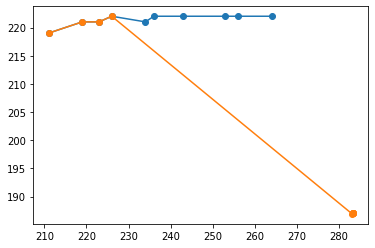

tensor([[223.0000, 221.0000],
        [226.0000, 222.0000],
        [234.0000, 221.0000],
        [236.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


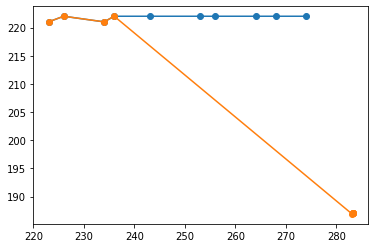

tensor([[234.0000, 221.0000],
        [236.0000, 222.0000],
        [243.0000, 222.0000],
        [253.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


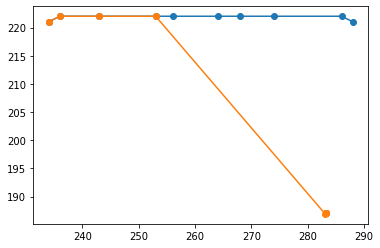

tensor([[243.0000, 222.0000],
        [253.0000, 222.0000],
        [256.0000, 222.0000],
        [264.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


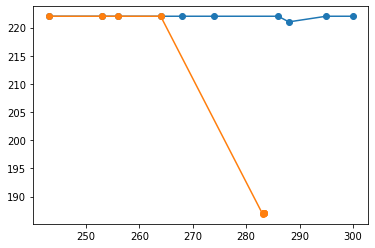

tensor([[256.0000, 222.0000],
        [264.0000, 222.0000],
        [268.0000, 222.0000],
        [274.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


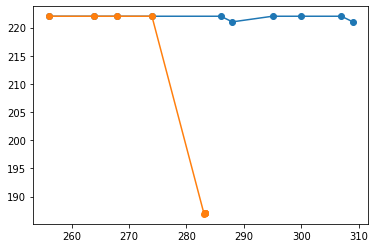

tensor([[268.0000, 222.0000],
        [274.0000, 222.0000],
        [286.0000, 222.0000],
        [288.0000, 221.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


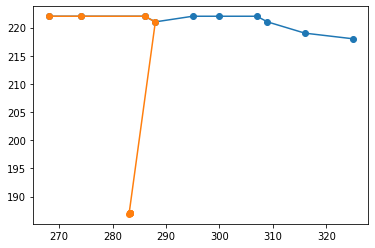

tensor([[286.0000, 222.0000],
        [288.0000, 221.0000],
        [295.0000, 222.0000],
        [300.0000, 222.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


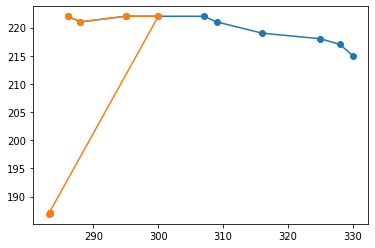

tensor([[295.0000, 222.0000],
        [300.0000, 222.0000],
        [307.0000, 222.0000],
        [309.0000, 221.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


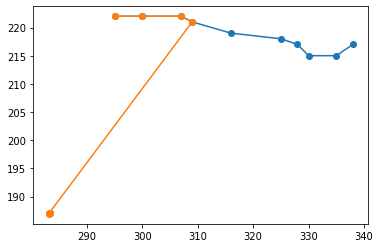

tensor([[307.0000, 222.0000],
        [309.0000, 221.0000],
        [316.0000, 219.0000],
        [325.0000, 218.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


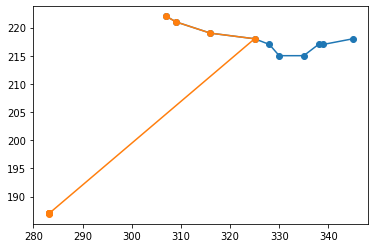

tensor([[316.0000, 219.0000],
        [325.0000, 218.0000],
        [328.0000, 217.0000],
        [330.0000, 215.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


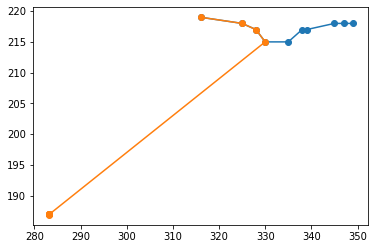

tensor([[328.0000, 217.0000],
        [330.0000, 215.0000],
        [335.0000, 215.0000],
        [338.0000, 217.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


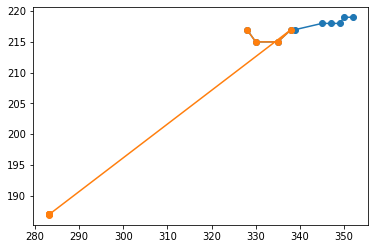

tensor([[188.0000, 221.0000],
        [189.0000, 222.0000],
        [192.0000, 223.0000],
        [193.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


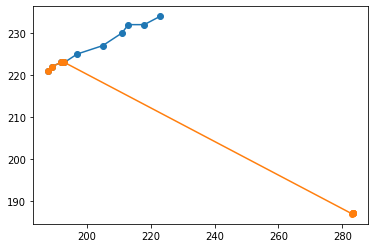

tensor([[192.0000, 223.0000],
        [193.0000, 223.0000],
        [197.0000, 225.0000],
        [205.0000, 227.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


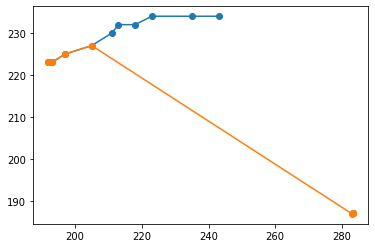

tensor([[197.0000, 225.0000],
        [205.0000, 227.0000],
        [211.0000, 230.0000],
        [213.0000, 232.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


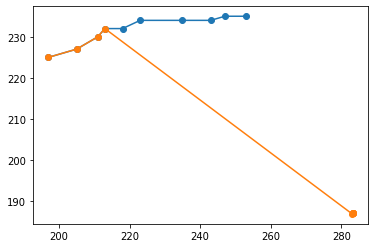

tensor([[211.0000, 230.0000],
        [213.0000, 232.0000],
        [218.0000, 232.0000],
        [223.0000, 234.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


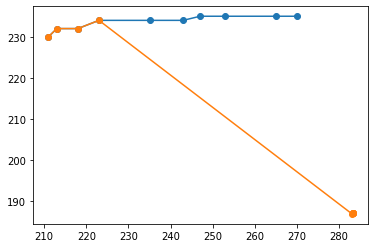

tensor([[218.0000, 232.0000],
        [223.0000, 234.0000],
        [235.0000, 234.0000],
        [243.0000, 234.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


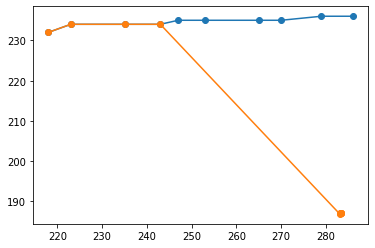

tensor([[235.0000, 234.0000],
        [243.0000, 234.0000],
        [247.0000, 235.0000],
        [253.0000, 235.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


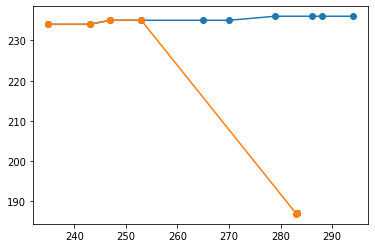

tensor([[247.0000, 235.0000],
        [253.0000, 235.0000],
        [265.0000, 235.0000],
        [270.0000, 235.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


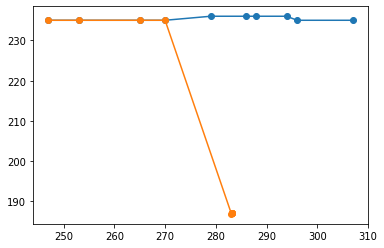

tensor([[265.0000, 235.0000],
        [270.0000, 235.0000],
        [279.0000, 236.0000],
        [286.0000, 236.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


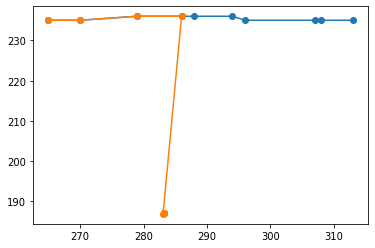

tensor([[279.0000, 236.0000],
        [286.0000, 236.0000],
        [288.0000, 236.0000],
        [294.0000, 236.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


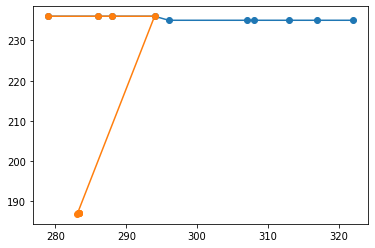

tensor([[288.0000, 236.0000],
        [294.0000, 236.0000],
        [296.0000, 235.0000],
        [307.0000, 235.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


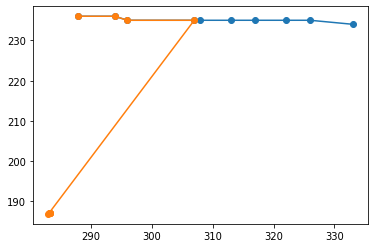

tensor([[296.0000, 235.0000],
        [307.0000, 235.0000],
        [308.0000, 235.0000],
        [313.0000, 235.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


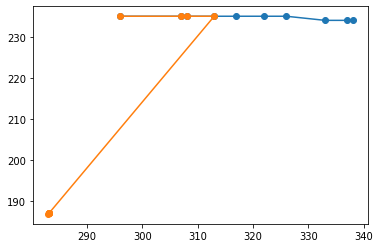

tensor([[308.0000, 235.0000],
        [313.0000, 235.0000],
        [317.0000, 235.0000],
        [322.0000, 235.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


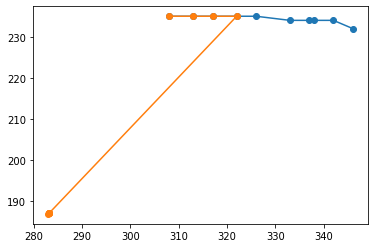

tensor([[317.0000, 235.0000],
        [322.0000, 235.0000],
        [326.0000, 235.0000],
        [333.0000, 234.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


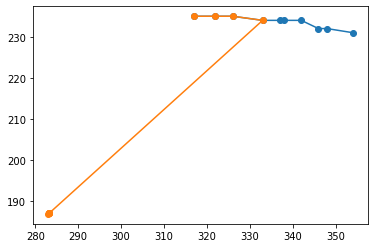

tensor([[326.0000, 235.0000],
        [333.0000, 234.0000],
        [337.0000, 234.0000],
        [338.0000, 234.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


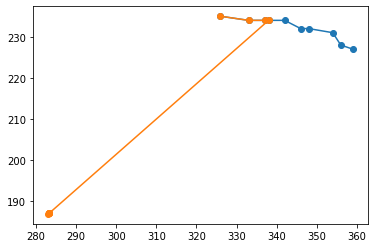

tensor([[337.0000, 234.0000],
        [338.0000, 234.0000],
        [342.0000, 234.0000],
        [346.0000, 232.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


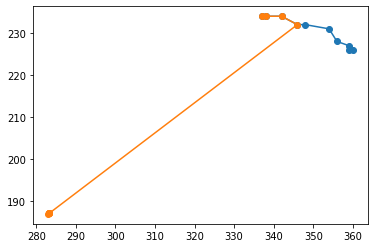

tensor([[342.0000, 234.0000],
        [346.0000, 232.0000],
        [348.0000, 232.0000],
        [354.0000, 231.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


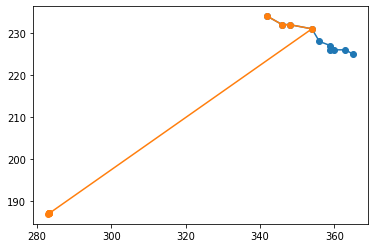

tensor([[193.0000, 218.0000],
        [196.0000, 221.0000],
        [200.0000, 223.0000],
        [202.0000, 223.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


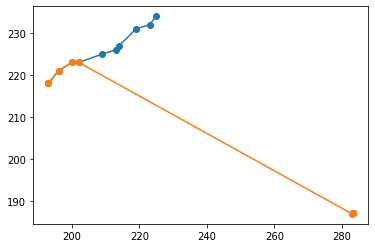

tensor([[200.0000, 223.0000],
        [202.0000, 223.0000],
        [209.0000, 225.0000],
        [213.0000, 226.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


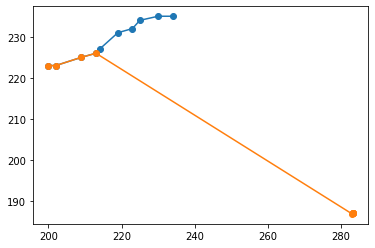

tensor([[209.0000, 225.0000],
        [213.0000, 226.0000],
        [214.0000, 227.0000],
        [219.0000, 231.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


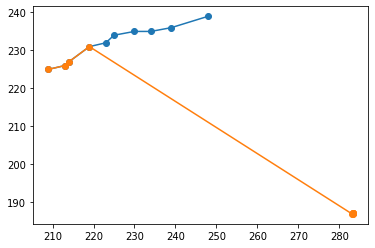

tensor([[214.0000, 227.0000],
        [219.0000, 231.0000],
        [223.0000, 232.0000],
        [225.0000, 234.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


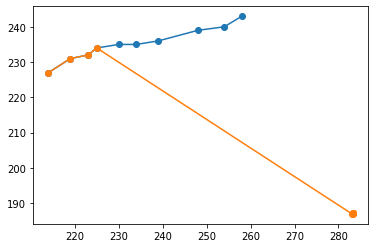

tensor([[223.0000, 232.0000],
        [225.0000, 234.0000],
        [230.0000, 235.0000],
        [234.0000, 235.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


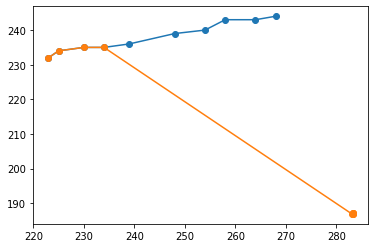

tensor([[230.0000, 235.0000],
        [234.0000, 235.0000],
        [239.0000, 236.0000],
        [248.0000, 239.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


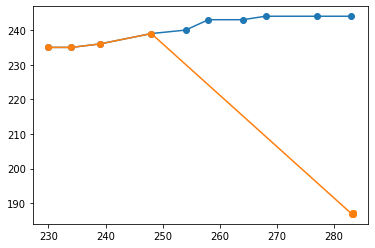

tensor([[239.0000, 236.0000],
        [248.0000, 239.0000],
        [254.0000, 240.0000],
        [258.0000, 243.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


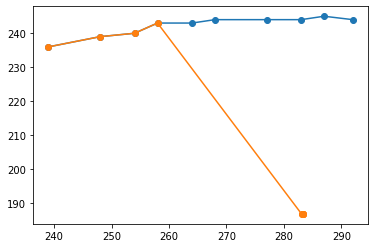

tensor([[254.0000, 240.0000],
        [258.0000, 243.0000],
        [264.0000, 243.0000],
        [268.0000, 244.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


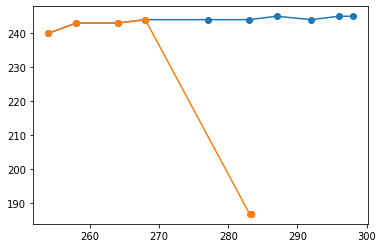

tensor([[264.0000, 243.0000],
        [268.0000, 244.0000],
        [277.0000, 244.0000],
        [283.0000, 244.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


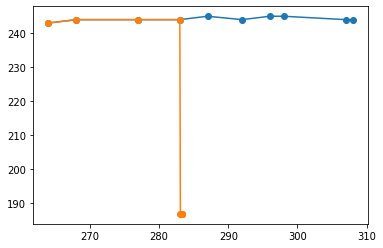

tensor([[277.0000, 244.0000],
        [283.0000, 244.0000],
        [287.0000, 245.0000],
        [292.0000, 244.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


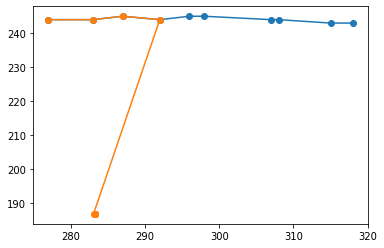

tensor([[287.0000, 245.0000],
        [292.0000, 244.0000],
        [296.0000, 245.0000],
        [298.0000, 245.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


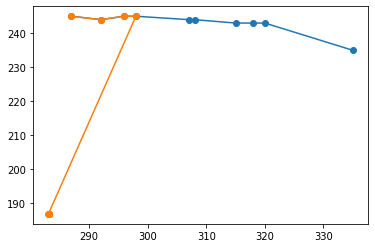

tensor([[296.0000, 245.0000],
        [298.0000, 245.0000],
        [307.0000, 244.0000],
        [308.0000, 244.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


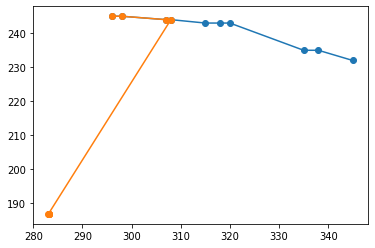

tensor([[307.0000, 244.0000],
        [308.0000, 244.0000],
        [315.0000, 243.0000],
        [318.0000, 243.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([0.], device='cuda:0')


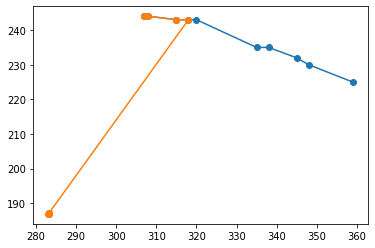

tensor([[191.0000, 214.0000],
        [192.0000, 214.0000],
        [193.0000, 214.0000],
        [196.0000, 214.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


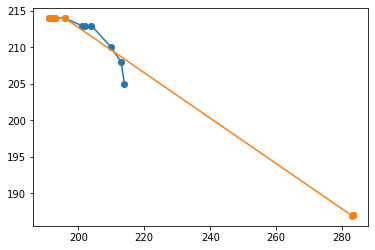

tensor([[193.0000, 214.0000],
        [196.0000, 214.0000],
        [201.0000, 213.0000],
        [202.0000, 213.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


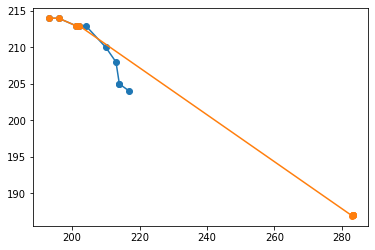

tensor([[201.0000, 213.0000],
        [202.0000, 213.0000],
        [204.0000, 213.0000],
        [210.0000, 210.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


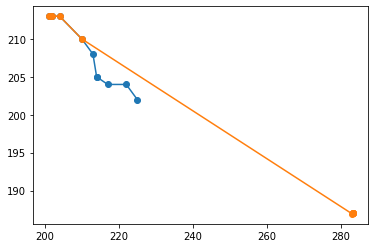

tensor([[204.0000, 213.0000],
        [210.0000, 210.0000],
        [213.0000, 208.0000],
        [214.0000, 205.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


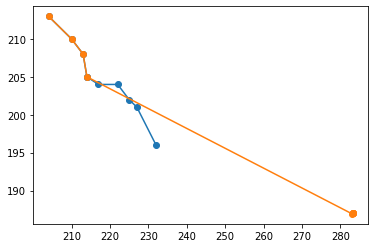

tensor([[213.0000, 208.0000],
        [214.0000, 205.0000],
        [214.0000, 205.0000],
        [217.0000, 204.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


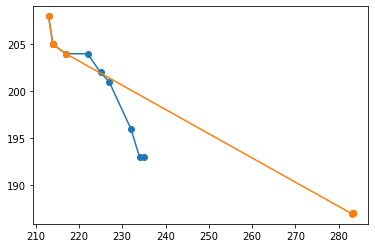

tensor([[214.0000, 205.0000],
        [217.0000, 204.0000],
        [222.0000, 204.0000],
        [225.0000, 202.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


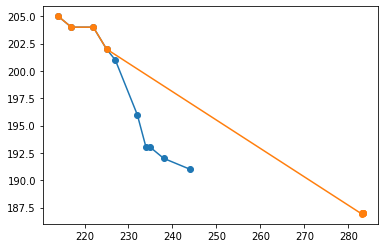

tensor([[222.0000, 204.0000],
        [225.0000, 202.0000],
        [227.0000, 201.0000],
        [232.0000, 196.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


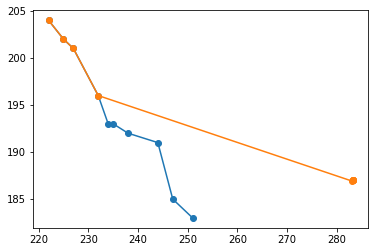

tensor([[227.0000, 201.0000],
        [232.0000, 196.0000],
        [234.0000, 193.0000],
        [235.0000, 193.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


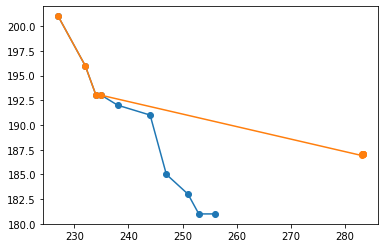

tensor([[234.0000, 193.0000],
        [235.0000, 193.0000],
        [238.0000, 192.0000],
        [244.0000, 191.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


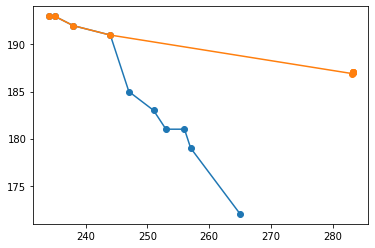

tensor([[238.0000, 192.0000],
        [244.0000, 191.0000],
        [247.0000, 185.0000],
        [251.0000, 183.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


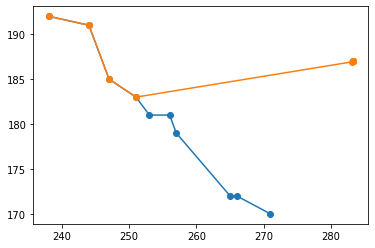

tensor([[247.0000, 185.0000],
        [251.0000, 183.0000],
        [253.0000, 181.0000],
        [256.0000, 181.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


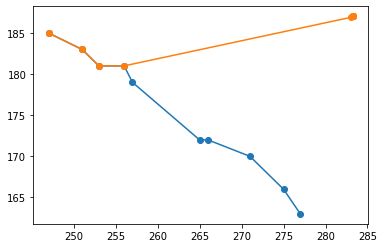

tensor([[253.0000, 181.0000],
        [256.0000, 181.0000],
        [257.0000, 179.0000],
        [265.0000, 172.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


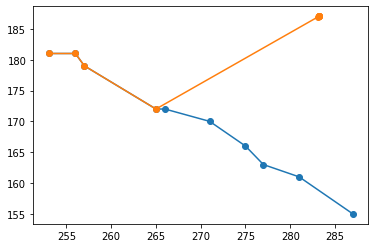

tensor([[257.0000, 179.0000],
        [265.0000, 172.0000],
        [266.0000, 172.0000],
        [271.0000, 170.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


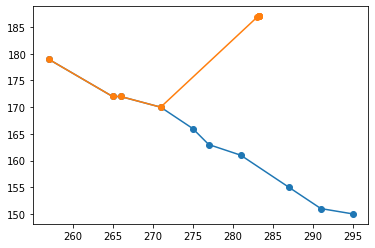

tensor([[266.0000, 172.0000],
        [271.0000, 170.0000],
        [275.0000, 166.0000],
        [277.0000, 163.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


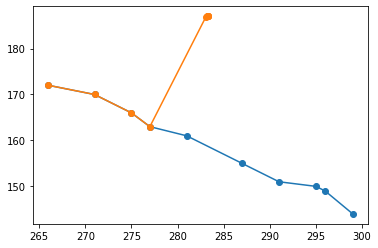

tensor([[275.0000, 166.0000],
        [277.0000, 163.0000],
        [281.0000, 161.0000],
        [287.0000, 155.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


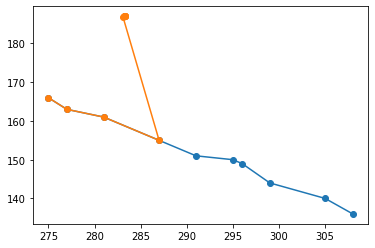

tensor([[281.0000, 161.0000],
        [287.0000, 155.0000],
        [291.0000, 151.0000],
        [295.0000, 150.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


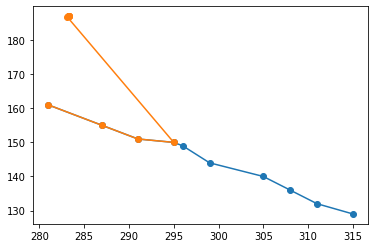

tensor([[291.0000, 151.0000],
        [295.0000, 150.0000],
        [296.0000, 149.0000],
        [299.0000, 144.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


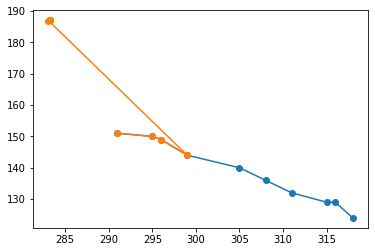

tensor([[296.0000, 149.0000],
        [299.0000, 144.0000],
        [305.0000, 140.0000],
        [308.0000, 136.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


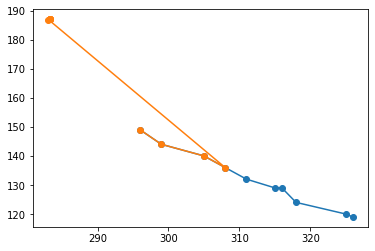

tensor([[305.0000, 140.0000],
        [308.0000, 136.0000],
        [311.0000, 132.0000],
        [315.0000, 129.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


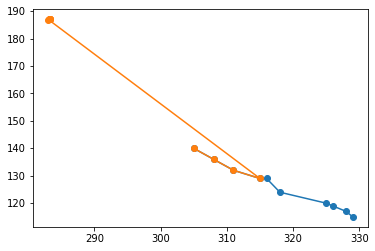

tensor([[311.0000, 132.0000],
        [315.0000, 129.0000],
        [316.0000, 129.0000],
        [318.0000, 124.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


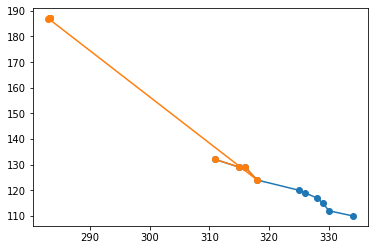

tensor([[316.0000, 129.0000],
        [318.0000, 124.0000],
        [325.0000, 120.0000],
        [326.0000, 119.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


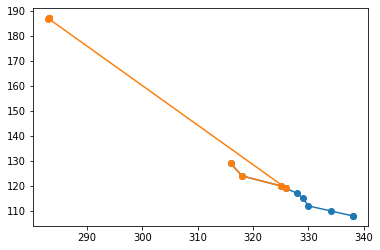

tensor([[325.0000, 120.0000],
        [326.0000, 119.0000],
        [328.0000, 117.0000],
        [329.0000, 115.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


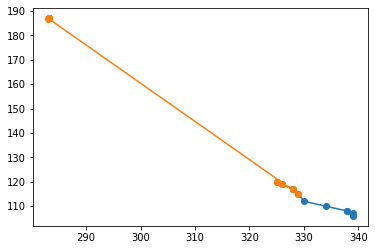

tensor([[328.0000, 117.0000],
        [329.0000, 115.0000],
        [330.0000, 112.0000],
        [334.0000, 110.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


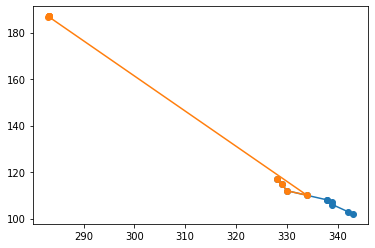

tensor([[185.0000, 215.0000],
        [187.0000, 215.0000],
        [185.0000, 215.0000],
        [189.0000, 215.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


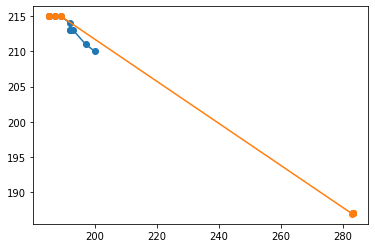

tensor([[185.0000, 215.0000],
        [189.0000, 215.0000],
        [192.0000, 214.0000],
        [192.0000, 213.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


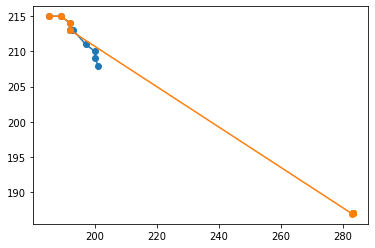

tensor([[192.0000, 214.0000],
        [192.0000, 213.0000],
        [192.0000, 213.0000],
        [193.0000, 213.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


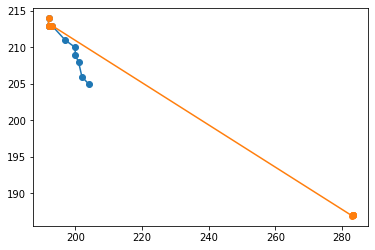

tensor([[192.0000, 213.0000],
        [193.0000, 213.0000],
        [197.0000, 211.0000],
        [200.0000, 210.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


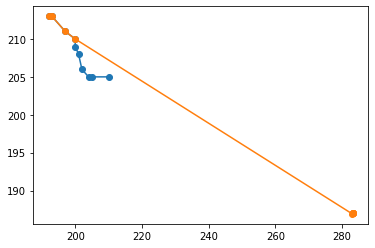

tensor([[197.0000, 211.0000],
        [200.0000, 210.0000],
        [200.0000, 209.0000],
        [201.0000, 208.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


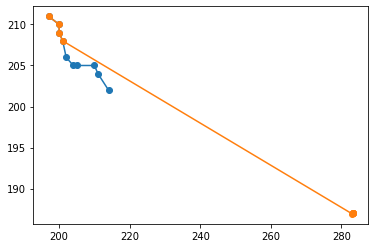

tensor([[200.0000, 209.0000],
        [201.0000, 208.0000],
        [202.0000, 206.0000],
        [204.0000, 205.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


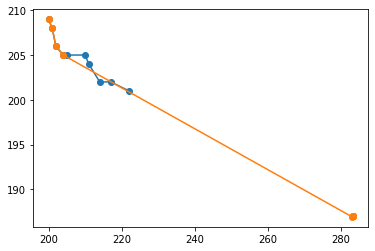

tensor([[202.0000, 206.0000],
        [204.0000, 205.0000],
        [205.0000, 205.0000],
        [210.0000, 205.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


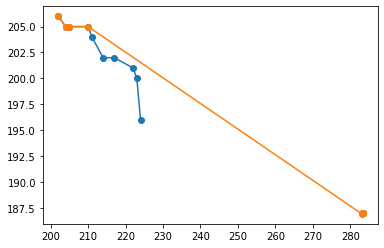

tensor([[205.0000, 205.0000],
        [210.0000, 205.0000],
        [211.0000, 204.0000],
        [214.0000, 202.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


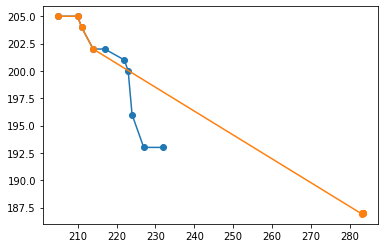

tensor([[211.0000, 204.0000],
        [214.0000, 202.0000],
        [217.0000, 202.0000],
        [222.0000, 201.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


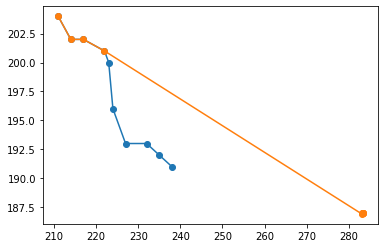

tensor([[217.0000, 202.0000],
        [222.0000, 201.0000],
        [223.0000, 200.0000],
        [224.0000, 196.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


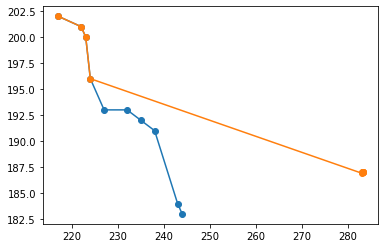

tensor([[223.0000, 200.0000],
        [224.0000, 196.0000],
        [227.0000, 193.0000],
        [232.0000, 193.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


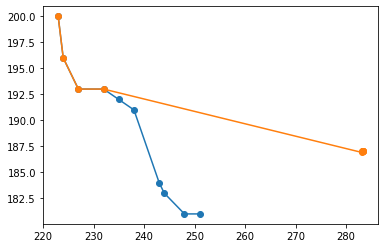

tensor([[227.0000, 193.0000],
        [232.0000, 193.0000],
        [235.0000, 192.0000],
        [238.0000, 191.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


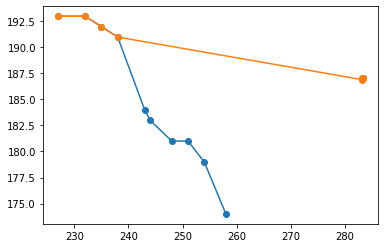

tensor([[235.0000, 192.0000],
        [238.0000, 191.0000],
        [243.0000, 184.0000],
        [244.0000, 183.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


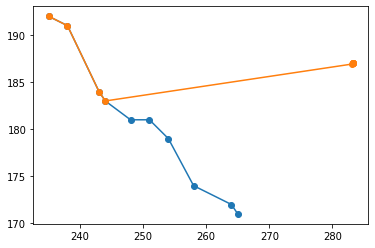

tensor([[243.0000, 184.0000],
        [244.0000, 183.0000],
        [248.0000, 181.0000],
        [251.0000, 181.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


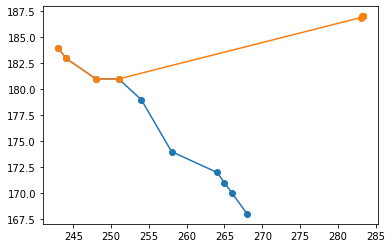

tensor([[248.0000, 181.0000],
        [251.0000, 181.0000],
        [254.0000, 179.0000],
        [258.0000, 174.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


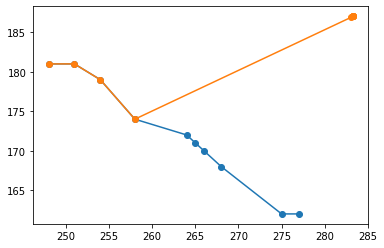

tensor([[254.0000, 179.0000],
        [258.0000, 174.0000],
        [264.0000, 172.0000],
        [265.0000, 171.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


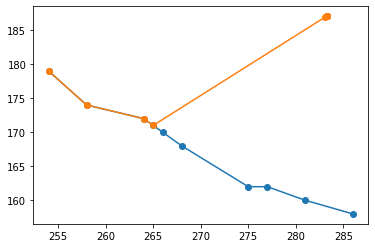

tensor([[264.0000, 172.0000],
        [265.0000, 171.0000],
        [266.0000, 170.0000],
        [268.0000, 168.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


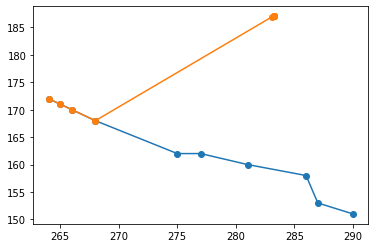

tensor([[266.0000, 170.0000],
        [268.0000, 168.0000],
        [275.0000, 162.0000],
        [277.0000, 162.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


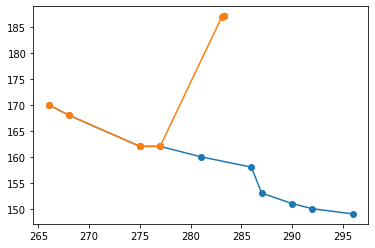

tensor([[275.0000, 162.0000],
        [277.0000, 162.0000],
        [281.0000, 160.0000],
        [286.0000, 158.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


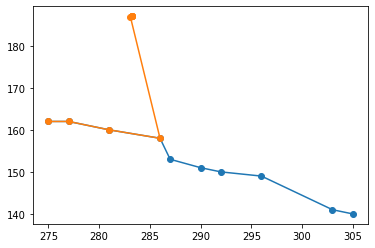

tensor([[281.0000, 160.0000],
        [286.0000, 158.0000],
        [287.0000, 153.0000],
        [290.0000, 151.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


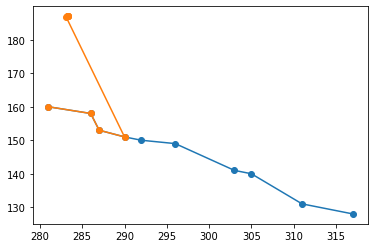

tensor([[287.0000, 153.0000],
        [290.0000, 151.0000],
        [292.0000, 150.0000],
        [296.0000, 149.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


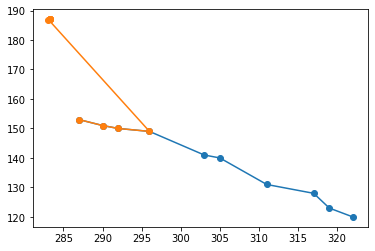

tensor([[292.0000, 150.0000],
        [296.0000, 149.0000],
        [303.0000, 141.0000],
        [305.0000, 140.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


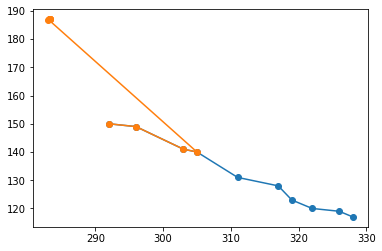

tensor([[303.0000, 141.0000],
        [305.0000, 140.0000],
        [311.0000, 131.0000],
        [317.0000, 128.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


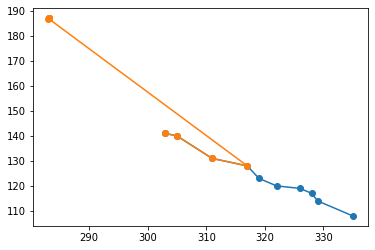

tensor([[311.0000, 131.0000],
        [317.0000, 128.0000],
        [319.0000, 123.0000],
        [322.0000, 120.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


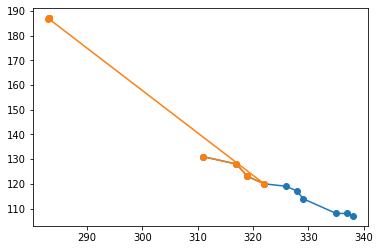

tensor([[319.0000, 123.0000],
        [322.0000, 120.0000],
        [326.0000, 119.0000],
        [328.0000, 117.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


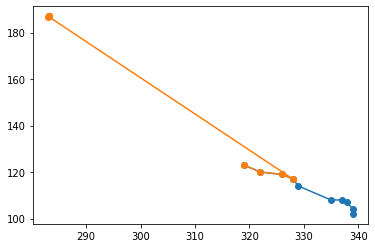

tensor([[326.0000, 119.0000],
        [328.0000, 117.0000],
        [329.0000, 114.0000],
        [335.0000, 108.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


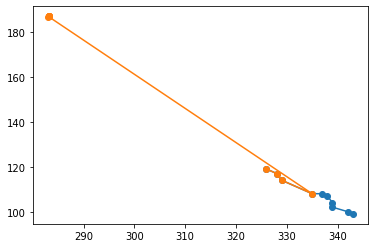

tensor([[191.0000, 219.0000],
        [192.0000, 218.0000],
        [193.0000, 219.0000],
        [200.0000, 217.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


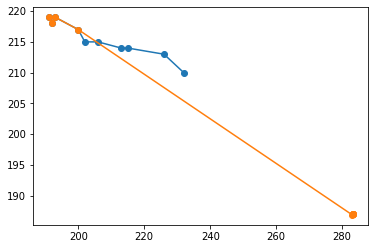

tensor([[193.0000, 219.0000],
        [200.0000, 217.0000],
        [202.0000, 215.0000],
        [206.0000, 215.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


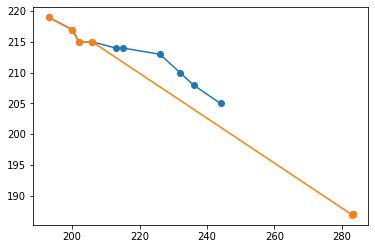

tensor([[202.0000, 215.0000],
        [206.0000, 215.0000],
        [213.0000, 214.0000],
        [215.0000, 214.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


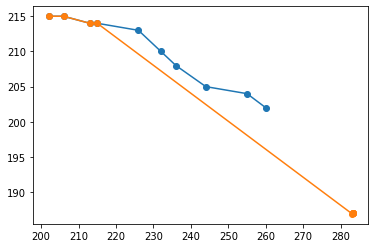

tensor([[213.0000, 214.0000],
        [215.0000, 214.0000],
        [226.0000, 213.0000],
        [232.0000, 210.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


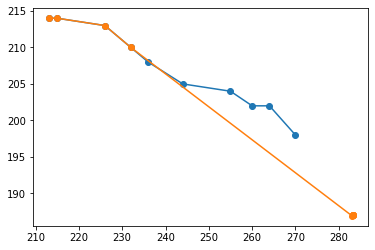

tensor([[226.0000, 213.0000],
        [232.0000, 210.0000],
        [236.0000, 208.0000],
        [244.0000, 205.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


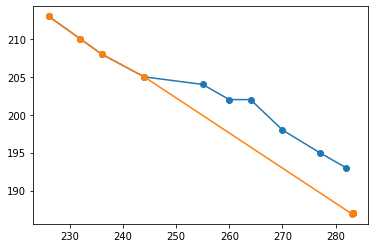

tensor([[236.0000, 208.0000],
        [244.0000, 205.0000],
        [255.0000, 204.0000],
        [260.0000, 202.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


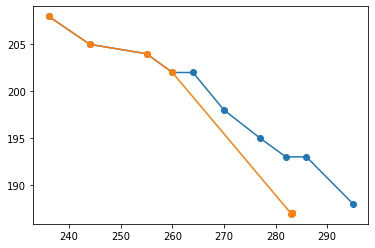

tensor([[255.0000, 204.0000],
        [260.0000, 202.0000],
        [264.0000, 202.0000],
        [270.0000, 198.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


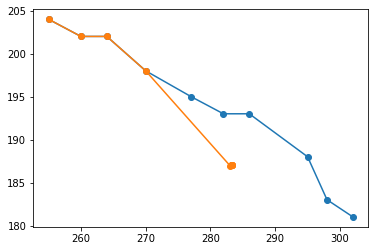

tensor([[264.0000, 202.0000],
        [270.0000, 198.0000],
        [277.0000, 195.0000],
        [282.0000, 193.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


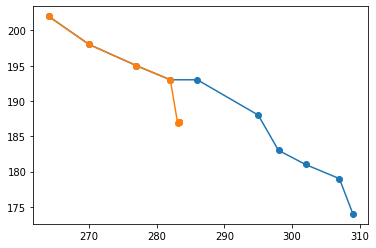

tensor([[277.0000, 195.0000],
        [282.0000, 193.0000],
        [286.0000, 193.0000],
        [295.0000, 188.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


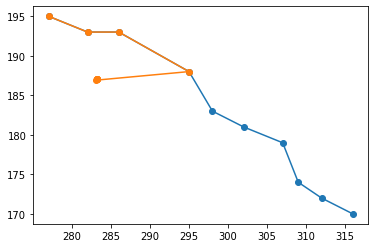

tensor([[286.0000, 193.0000],
        [295.0000, 188.0000],
        [298.0000, 183.0000],
        [302.0000, 181.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


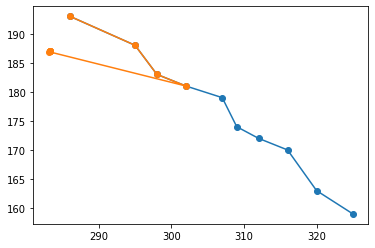

tensor([[298.0000, 183.0000],
        [302.0000, 181.0000],
        [307.0000, 179.0000],
        [309.0000, 174.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


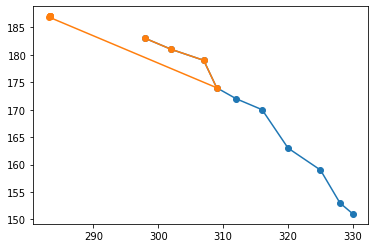

tensor([[307.0000, 179.0000],
        [309.0000, 174.0000],
        [312.0000, 172.0000],
        [316.0000, 170.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


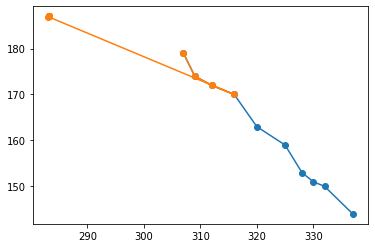

tensor([[312.0000, 172.0000],
        [316.0000, 170.0000],
        [320.0000, 163.0000],
        [325.0000, 159.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


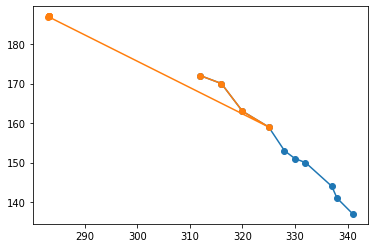

tensor([[320.0000, 163.0000],
        [325.0000, 159.0000],
        [328.0000, 153.0000],
        [330.0000, 151.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


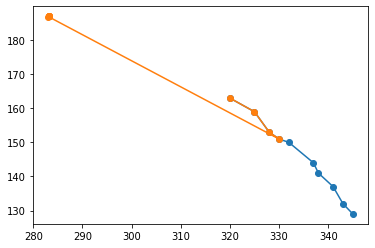

tensor([[328.0000, 153.0000],
        [330.0000, 151.0000],
        [332.0000, 150.0000],
        [337.0000, 144.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


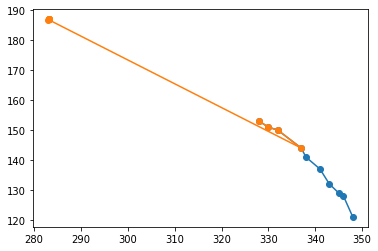

tensor([[332.0000, 150.0000],
        [337.0000, 144.0000],
        [338.0000, 141.0000],
        [341.0000, 137.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


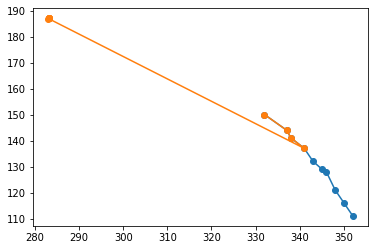

tensor([[338.0000, 141.0000],
        [341.0000, 137.0000],
        [343.0000, 132.0000],
        [345.0000, 129.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


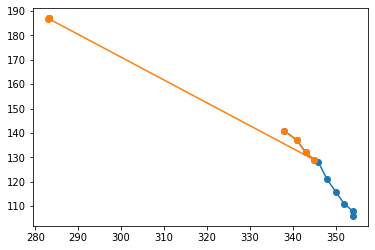

tensor([[343.0000, 132.0000],
        [345.0000, 129.0000],
        [346.0000, 128.0000],
        [348.0000, 121.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


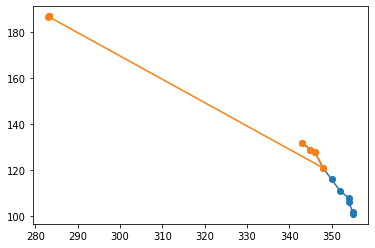

tensor([[184.0000, 215.0000],
        [184.0000, 214.0000],
        [191.0000, 214.0000],
        [192.0000, 214.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


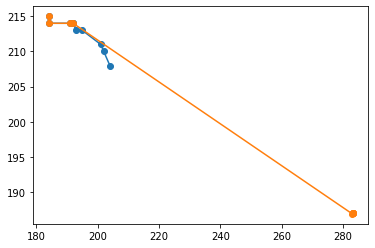

tensor([[191.0000, 214.0000],
        [192.0000, 214.0000],
        [192.0000, 214.0000],
        [193.0000, 213.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


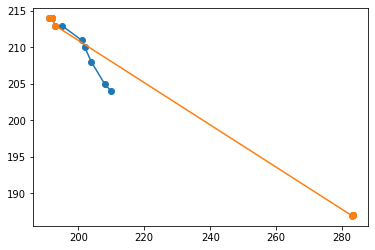

tensor([[192.0000, 214.0000],
        [193.0000, 213.0000],
        [195.0000, 213.0000],
        [201.0000, 211.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


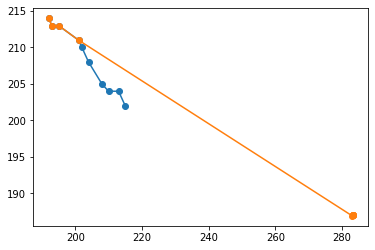

tensor([[195.0000, 213.0000],
        [201.0000, 211.0000],
        [202.0000, 210.0000],
        [204.0000, 208.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


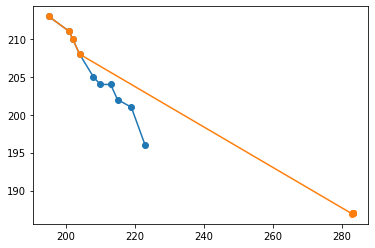

tensor([[202.0000, 210.0000],
        [204.0000, 208.0000],
        [208.0000, 205.0000],
        [210.0000, 204.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


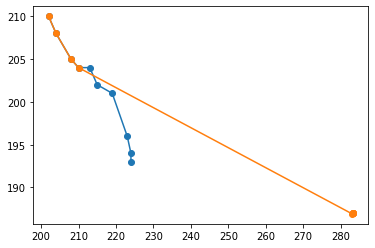

tensor([[208.0000, 205.0000],
        [210.0000, 204.0000],
        [213.0000, 204.0000],
        [215.0000, 202.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


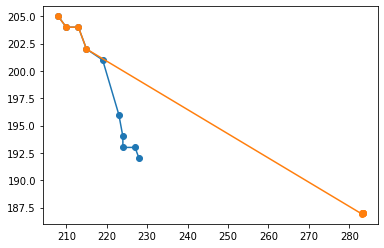

tensor([[213.0000, 204.0000],
        [215.0000, 202.0000],
        [219.0000, 201.0000],
        [223.0000, 196.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


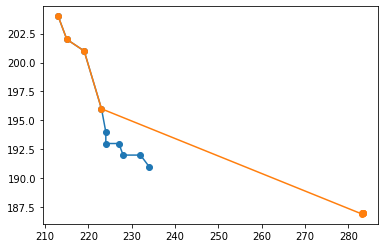

tensor([[219.0000, 201.0000],
        [223.0000, 196.0000],
        [224.0000, 194.0000],
        [224.0000, 193.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


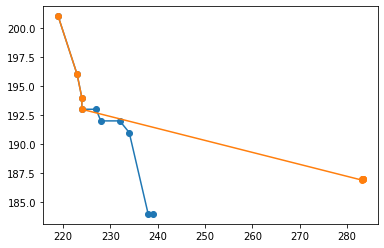

tensor([[224.0000, 194.0000],
        [224.0000, 193.0000],
        [227.0000, 193.0000],
        [228.0000, 192.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


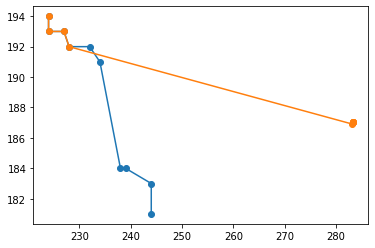

tensor([[227.0000, 193.0000],
        [228.0000, 192.0000],
        [232.0000, 192.0000],
        [234.0000, 191.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


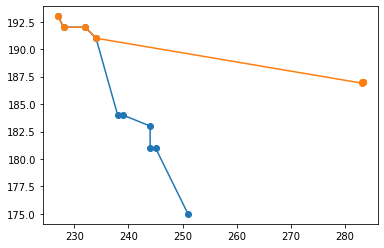

tensor([[232.0000, 192.0000],
        [234.0000, 191.0000],
        [238.0000, 184.0000],
        [239.0000, 184.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


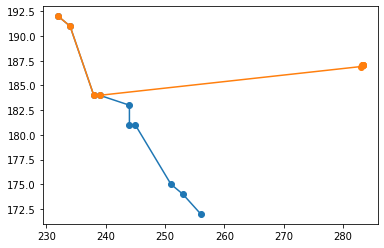

tensor([[238.0000, 184.0000],
        [239.0000, 184.0000],
        [244.0000, 183.0000],
        [244.0000, 181.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


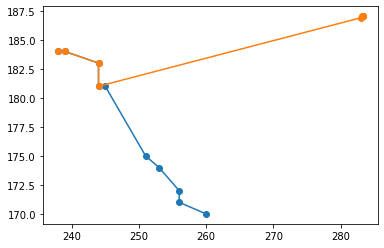

tensor([[244.0000, 183.0000],
        [244.0000, 181.0000],
        [245.0000, 181.0000],
        [251.0000, 175.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


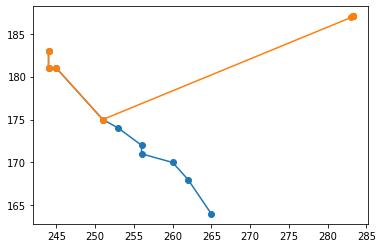

tensor([[245.0000, 181.0000],
        [251.0000, 175.0000],
        [253.0000, 174.0000],
        [256.0000, 172.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


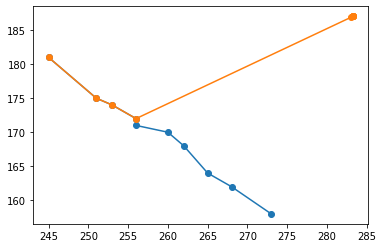

tensor([[253.0000, 174.0000],
        [256.0000, 172.0000],
        [256.0000, 171.0000],
        [260.0000, 170.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


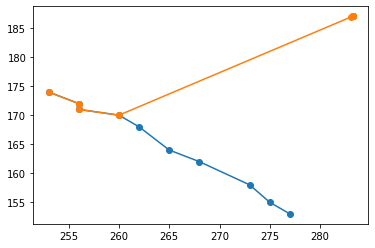

tensor([[256.0000, 171.0000],
        [260.0000, 170.0000],
        [262.0000, 168.0000],
        [265.0000, 164.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


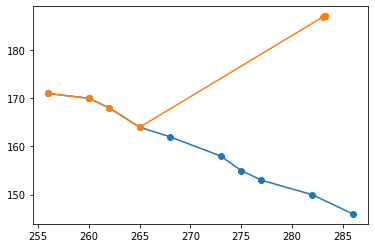

tensor([[262.0000, 168.0000],
        [265.0000, 164.0000],
        [268.0000, 162.0000],
        [273.0000, 158.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


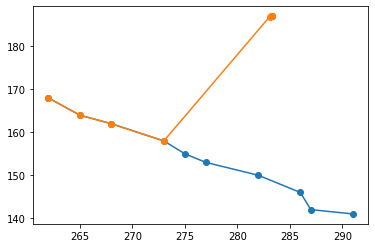

tensor([[268.0000, 162.0000],
        [273.0000, 158.0000],
        [275.0000, 155.0000],
        [277.0000, 153.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


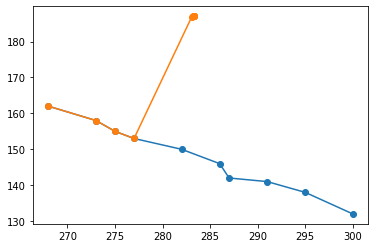

tensor([[275.0000, 155.0000],
        [277.0000, 153.0000],
        [282.0000, 150.0000],
        [286.0000, 146.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


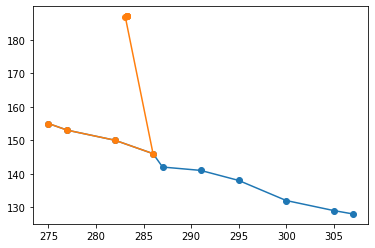

tensor([[282.0000, 150.0000],
        [286.0000, 146.0000],
        [287.0000, 142.0000],
        [291.0000, 141.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


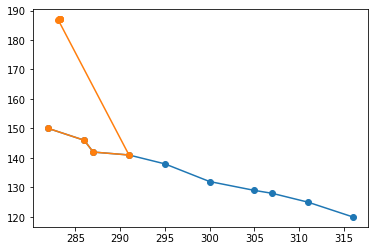

tensor([[287.0000, 142.0000],
        [291.0000, 141.0000],
        [295.0000, 138.0000],
        [300.0000, 132.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


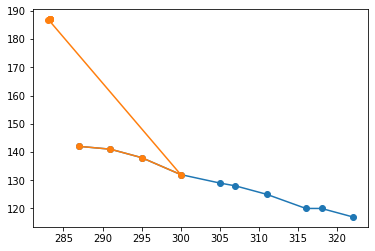

tensor([[295.0000, 138.0000],
        [300.0000, 132.0000],
        [305.0000, 129.0000],
        [307.0000, 128.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


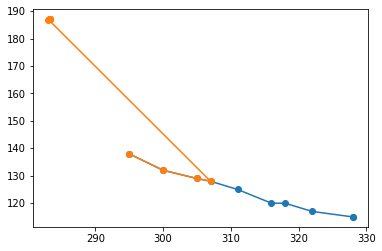

tensor([[305.0000, 129.0000],
        [307.0000, 128.0000],
        [311.0000, 125.0000],
        [316.0000, 120.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


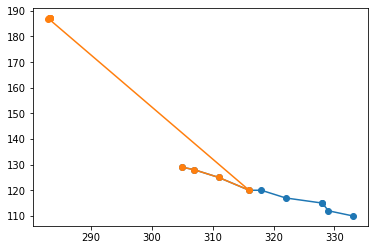

tensor([[311.0000, 125.0000],
        [316.0000, 120.0000],
        [318.0000, 120.0000],
        [322.0000, 117.0000],
        [283.0775, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0348],
        [283.2616, 187.0367],
        [283.2620, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


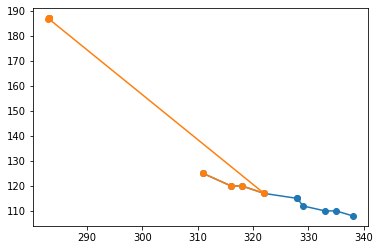

tensor([[318.0000, 120.0000],
        [322.0000, 117.0000],
        [328.0000, 115.0000],
        [328.0000, 115.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


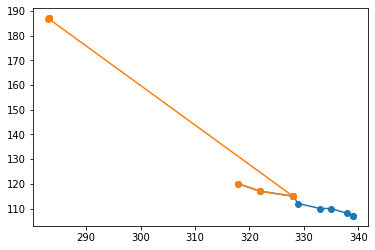

tensor([[328.0000, 115.0000],
        [328.0000, 115.0000],
        [329.0000, 112.0000],
        [333.0000, 110.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


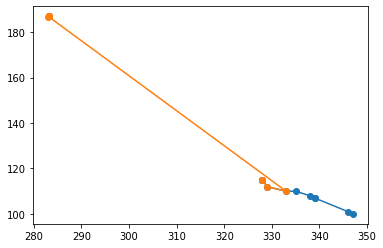

tensor([[184.0000, 219.0000],
        [185.0000, 219.0000],
        [189.0000, 218.0000],
        [191.0000, 219.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


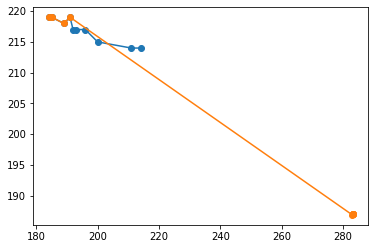

tensor([[189.0000, 218.0000],
        [191.0000, 219.0000],
        [192.0000, 217.0000],
        [193.0000, 217.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


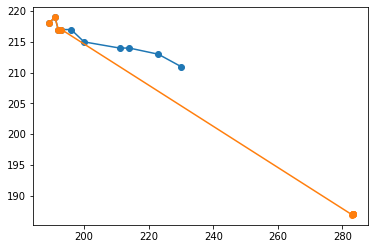

tensor([[192.0000, 217.0000],
        [193.0000, 217.0000],
        [196.0000, 217.0000],
        [200.0000, 215.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


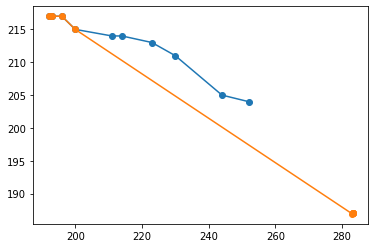

tensor([[196.0000, 217.0000],
        [200.0000, 215.0000],
        [211.0000, 214.0000],
        [214.0000, 214.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


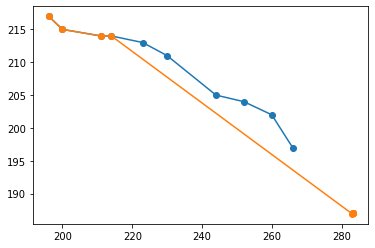

tensor([[211.0000, 214.0000],
        [214.0000, 214.0000],
        [223.0000, 213.0000],
        [230.0000, 211.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


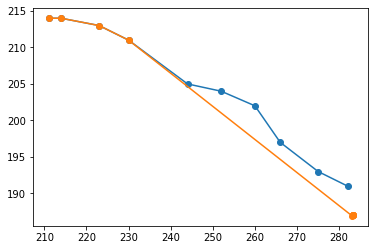

tensor([[223.0000, 213.0000],
        [230.0000, 211.0000],
        [244.0000, 205.0000],
        [252.0000, 204.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


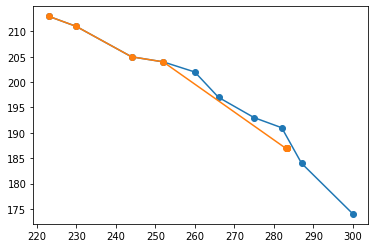

tensor([[244.0000, 205.0000],
        [252.0000, 204.0000],
        [260.0000, 202.0000],
        [266.0000, 197.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


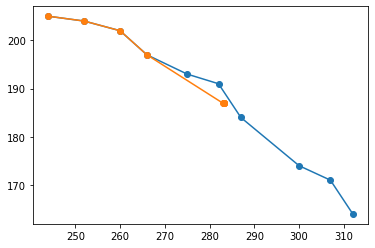

tensor([[260.0000, 202.0000],
        [266.0000, 197.0000],
        [275.0000, 193.0000],
        [282.0000, 191.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


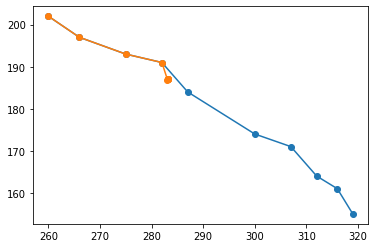

tensor([[275.0000, 193.0000],
        [282.0000, 191.0000],
        [287.0000, 184.0000],
        [300.0000, 174.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


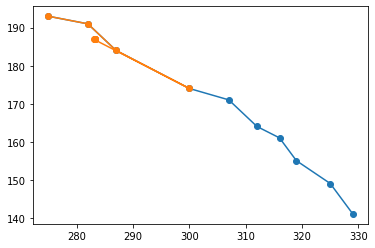

tensor([[287.0000, 184.0000],
        [300.0000, 174.0000],
        [307.0000, 171.0000],
        [312.0000, 164.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


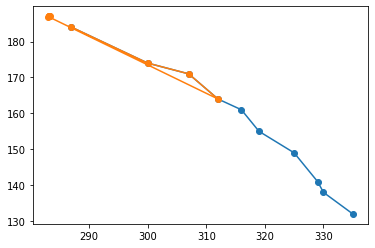

tensor([[307.0000, 171.0000],
        [312.0000, 164.0000],
        [316.0000, 161.0000],
        [319.0000, 155.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


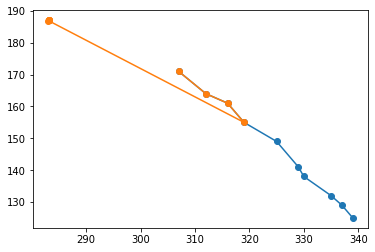

tensor([[316.0000, 161.0000],
        [319.0000, 155.0000],
        [325.0000, 149.0000],
        [329.0000, 141.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


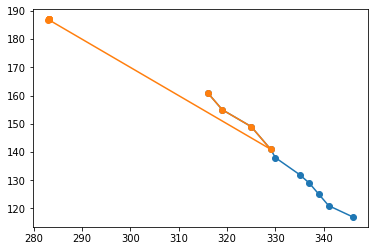

tensor([[325.0000, 149.0000],
        [329.0000, 141.0000],
        [330.0000, 138.0000],
        [335.0000, 132.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


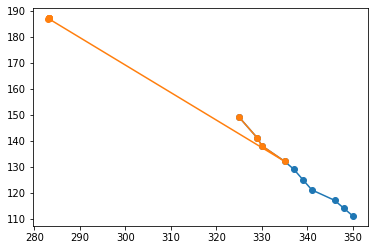

tensor([[330.0000, 138.0000],
        [335.0000, 132.0000],
        [337.0000, 129.0000],
        [339.0000, 125.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


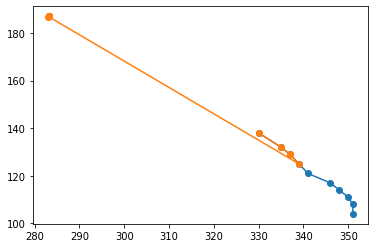

tensor([[337.0000, 129.0000],
        [339.0000, 125.0000],
        [341.0000, 121.0000],
        [346.0000, 117.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


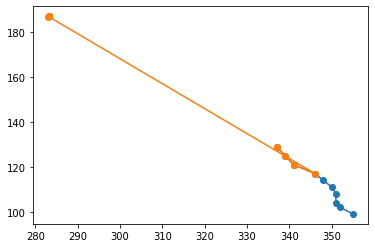

tensor([[341.0000, 121.0000],
        [346.0000, 117.0000],
        [348.0000, 114.0000],
        [350.0000, 111.0000],
        [283.0774, 186.9150],
        [283.2371, 187.0205],
        [283.2587, 187.0347],
        [283.2616, 187.0367],
        [283.2619, 187.0370],
        [283.2620, 187.0370]])
tensor([1.], device='cuda:0')


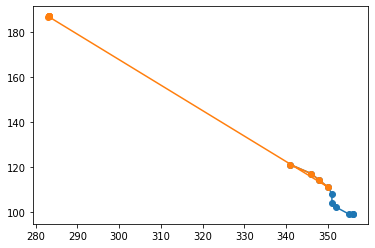

In [37]:
name_checkpoint = "211015_213739"
test(loader_test, name_checkpoint)